In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.preprocessing import StandardScaler



### Load the Dataset

The dataset is stored in a CSV file. We'll define the file path and load it into a pandas DataFrame.


In [2]:
data_dir = "/kaggle/input/healthcare-diabetes/Healthcare-Diabetes.csv"

In [3]:
df = pd.read_csv(data_dir)
df


,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...,...
2763,2764,2,75,64,24,55,29.7,0.370,33,0
2764,2765,8,179,72,42,130,32.7,0.719,36,1
2765,2766,6,85,78,0,0,31.2,0.382,42,0
2766,2767,0,129,110,46,130,67.1,0.319,26,1


In [4]:
df.head()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        2768 non-null   int64  
 1   Pregnancies               2768 non-null   int64  
 2   Glucose                   2768 non-null   int64  
 3   BloodPressure             2768 non-null   int64  
 4   SkinThickness             2768 non-null   int64  
 5   Insulin                   2768 non-null   int64  
 6   BMI                       2768 non-null   float64
 7   DiabetesPedigreeFunction  2768 non-null   float64
 8   Age                       2768 non-null   int64  
 9   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 216.4 KB


In [6]:
df.isnull().sum()

Id                          0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### Boxplot Comparison of Features by Outcome

We will visualize the distribution of each feature in the dataset with respect to the `Outcome` variable using boxplots. This helps identify patterns or differences in features between the two classes (0 and 1).


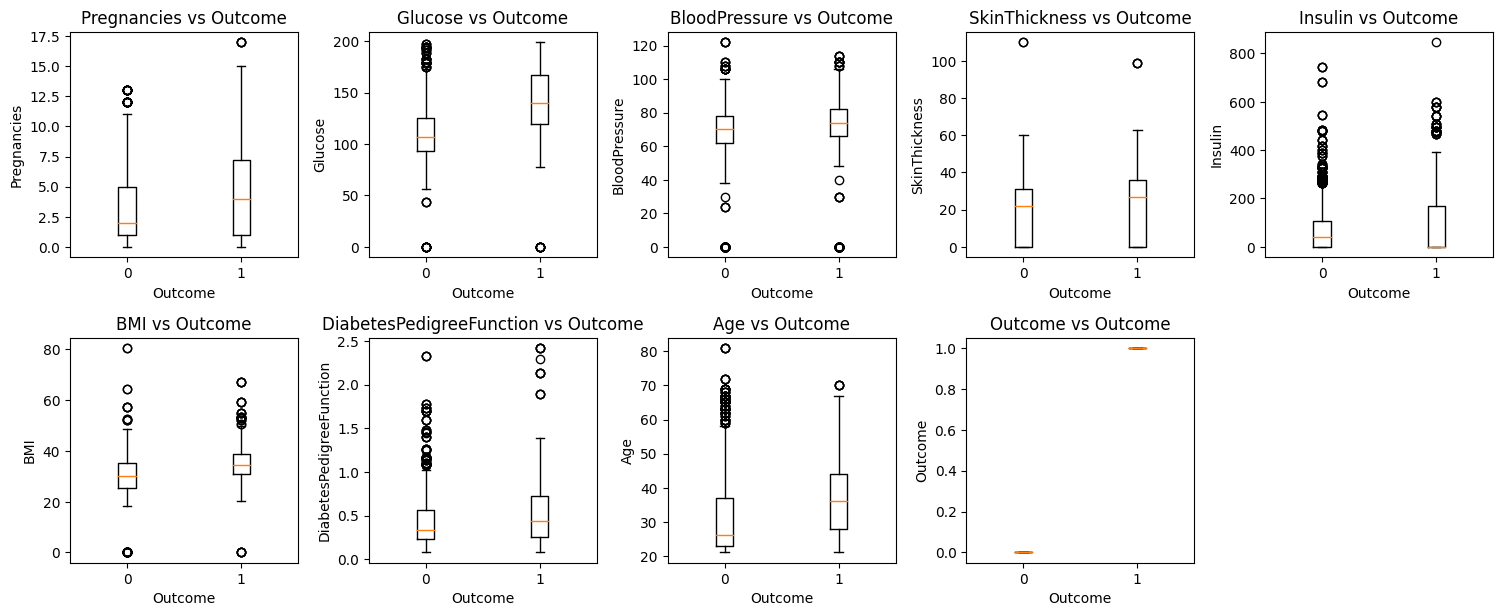

In [7]:
features = df.columns.drop("Id", "Outcome")
plt.figure( figsize=(15,15))
for i, col in enumerate(features, 1):
  plt.subplot(5,5,i)
  plt.boxplot([df[df["Outcome"]==0][col],df[df["Outcome"]==1][col]], labels=["0","1"])
  plt.title(f"{col} vs Outcome" )
  plt.xlabel("Outcome")
  plt.ylabel(col)

plt.tight_layout()
plt.show()

In [8]:
group_summary = df.groupby("Outcome").agg(["mean", "median"])
group_summary

Id         Pregnancies            Glucose         \
                mean  median        mean median        mean median   
Outcome                                                              
0        1388.143722  1377.5    3.204295    2.0  110.419604  107.0   
1        1377.549370  1405.5    4.769958    4.0  141.481092  140.0   

        BloodPressure        SkinThickness           Insulin         \
                 mean median          mean median       mean median   
Outcome                                                               
0           68.119493   70.0     19.945485   22.0  70.075991   42.5   
1           71.070378   74.0     22.501050   27.0  99.302521    0.0   

               BMI        DiabetesPedigreeFunction               Age         
              mean median                     mean median       mean median  
Outcome                                                                      
0        30.494989   30.1                 0.433316  0.340  31.111233   26.0  
1        35.270378   34.3                 0.543445  0.439  36.987395   36.0

### Average Feature Values by Outcome

This bar plot shows the mean values of each feature for the two outcome groups (0 and 1). It helps us quickly compare the central tendencies of features across the two classes.


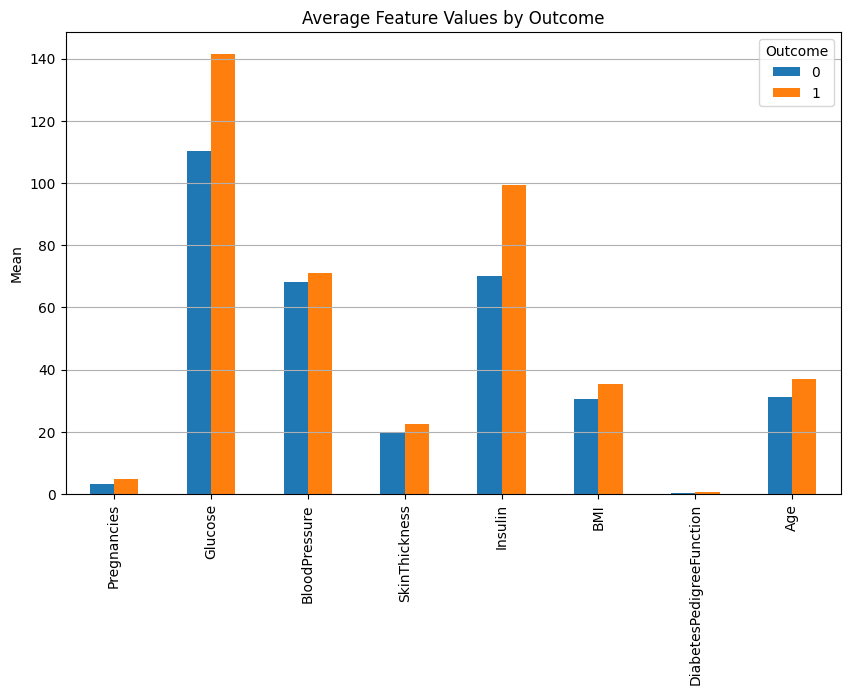

In [9]:
df.drop("Id", axis=1).groupby('Outcome').mean(numeric_only=True).T.plot(kind='bar', figsize=(10,6))
plt.title('Average Feature Values by Outcome')
plt.ylabel('Mean')
plt.grid(axis='y')
plt.show()


In [10]:
df.head()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


### Defining Features and Target

Here, we separate the dataset into input features (`x`) and the target variable (`y`).  
- `x` contains columns 1 to 8 (all feature columns except `Id` and `Outcome`).  
- `y` is the `Outcome` column that we want to predict.


In [11]:
x = df.iloc[:,1:9]
y = df["Outcome"]
print(x)
print(y)


      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0               6      148             72             35        0  33.6   
1               1       85             66             29        0  26.6   
2               8      183             64              0        0  23.3   
3               1       89             66             23       94  28.1   
4               0      137             40             35      168  43.1   
...           ...      ...            ...            ...      ...   ...   
2763            2       75             64             24       55  29.7   
2764            8      179             72             42      130  32.7   
2765            6       85             78              0        0  31.2   
2766            0      129            110             46      130  67.1   
2767            2       81             72             15       76  30.1   

      DiabetesPedigreeFunction  Age  
0                        0.627   50  
1                      

In [12]:
x.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [13]:
y.head()

0    1
1    0
2    1
3    0
4    1
Name: Outcome, dtype: int64

In [14]:
y = np.array(y, dtype="float32")

### Feature Scaling

We use `StandardScaler` to standardize the features. This scales the data so that each feature has a mean of 0 and a standard deviation of 1, which is important for many machine learning algorithms.


In [15]:
sc = StandardScaler()
x = sc.fit_transform(x)
x


array([[ 0.67923239,  0.83973755,  0.1490333 , ...,  0.18113541,
         0.47850939,  1.43249494],
       [-0.82534128, -1.12712422, -0.16301222, ..., -0.68577327,
        -0.36913043, -0.18107914],
       [ 1.28106186,  1.93243853, -0.26702739, ..., -1.09445879,
         0.61671153, -0.09615419],
       ...,
       [ 0.67923239, -1.12712422,  0.46107882, ..., -0.11609042,
        -0.2739245 ,  0.75309532],
       [-1.12625601,  0.24655701,  2.12532159, ...,  4.32991267,
        -0.4674075 , -0.6057039 ],
       [-0.52442655, -1.25200433,  0.1490333 , ..., -0.25231893,
         0.23281669, -0.69062885]])

In [16]:
x = torch.tensor(x)

In [17]:
y = torch.tensor(y)
y = y.unsqueeze(1)

In [18]:
print(x.shape)
print(y.shape)

torch.Size([2768, 8])
torch.Size([2768, 1])


### Creating a Custom PyTorch Dataset

We define a custom dataset class to wrap our features (`x`) and target (`y`) for PyTorch.  
This allows us to use PyTorch's `DataLoader` for batching and shuffling during model training.


In [19]:
class Dataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)


In [20]:
dataset = Dataset(x,y)

len(dataset)

2768

### Splitting the Dataset and Creating DataLoaders

We split the dataset into training (80%) and testing (20%) sets and create PyTorch `DataLoader`s.  
- `DataLoader` allows us to efficiently iterate over the dataset in batches and shuffle the data during training.


In [21]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [22]:
for x,y in train_loader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 8])
torch.Size([32, 1])


### Defining the Neural Network Model

We create a fully connected (dense) neural network using PyTorch's `nn.Module`.  
- The network has 5 linear layers with ReLU activations in between.  
- The output layer uses a sigmoid activation since this is a binary classification problem.


In [23]:
class model(nn.Module):
  def __init__(self, input_features, output_features):
    super(model, self).__init__()
    self.fc1 = nn.Linear(input_features, 32)
    self.fc2 = nn.Linear(32, 64)
    self.fc3 = nn.Linear(64, 56)
    self.fc4 = nn.Linear(56, 32)
    self.fc5 = nn.Linear(32, output_features)

    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)
    x = self.sigmoid(x)
    return x



In [24]:
network = model(8,1)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)

### Training the Neural Network

We train the model for 50 epochs using the training `DataLoader`.  

- For each batch, we perform a forward pass, compute the loss, backpropagate, and update the weights.  
- We track the training loss and accuracy at each epoch to monitor performance.  
- Predictions are thresholded at 0.5 since this is a binary classification problem.


In [25]:
train_losses = []
train_accuracies = []

epochs = 50
for epoch in range(epochs):

  train_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in train_loader:
    inputs = inputs.float()
    labels = labels.float()

    outputs =  network(inputs)
    loss = loss_fn(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    predicted = (outputs > 0.5).float()
    correct += (predicted == labels).sum().item()
    total += labels.numel()

  train_accuracy = correct/total
  train_loss = train_loss/len(train_loader)
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  print(f"Epoch: {epoch} and Accuracy: {train_accuracy:.6f}, Training Loss: {train_loss:.6f}")


Epoch: 0 and Accuracy: 0.659440, Training Loss: 0.597367
Epoch: 1 and Accuracy: 0.771454, Training Loss: 0.465181
Epoch: 2 and Accuracy: 0.786360, Training Loss: 0.448164
Epoch: 3 and Accuracy: 0.787715, Training Loss: 0.435696
Epoch: 4 and Accuracy: 0.802168, Training Loss: 0.425002
Epoch: 5 and Accuracy: 0.800361, Training Loss: 0.422563
Epoch: 6 and Accuracy: 0.810298, Training Loss: 0.404769
Epoch: 7 and Accuracy: 0.825203, Training Loss: 0.386830
Epoch: 8 and Accuracy: 0.828365, Training Loss: 0.374201
Epoch: 9 and Accuracy: 0.828817, Training Loss: 0.368599
Epoch: 10 and Accuracy: 0.845980, Training Loss: 0.335091
Epoch: 11 and Accuracy: 0.862692, Training Loss: 0.316636
Epoch: 12 and Accuracy: 0.870370, Training Loss: 0.296885
Epoch: 13 and Accuracy: 0.881210, Training Loss: 0.279666
Epoch: 14 and Accuracy: 0.890696, Training Loss: 0.266785
Epoch: 15 and Accuracy: 0.900181, Training Loss: 0.249745
Epoch: 16 and Accuracy: 0.906504, Training Loss: 0.234616
Epoch: 17 and Accuracy: 

### Plotting Training Loss

We visualize the training loss over epochs to monitor how well the model is learning.  
A decreasing loss indicates that the model is gradually improving on the training data.


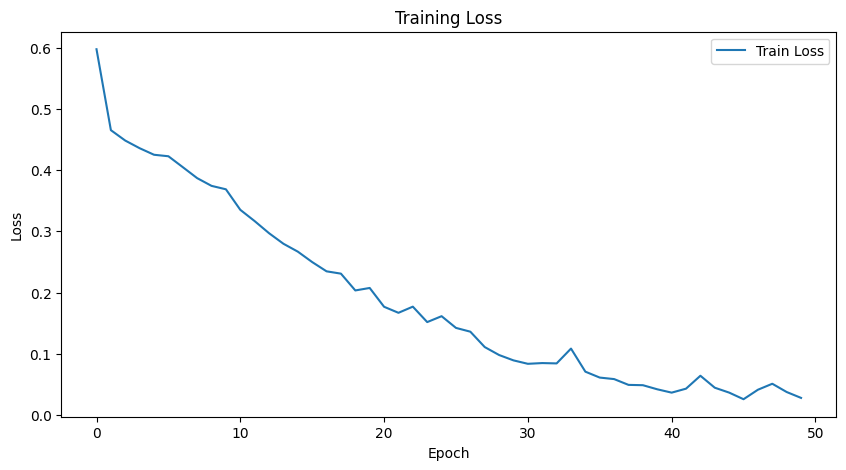

In [26]:
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

### Plotting Training Accuracy

We visualize the training accuracy over epochs to track how well the model is learning to classify the data.  
An increasing accuracy indicates that the model is improving in predicting the correct outcomes.


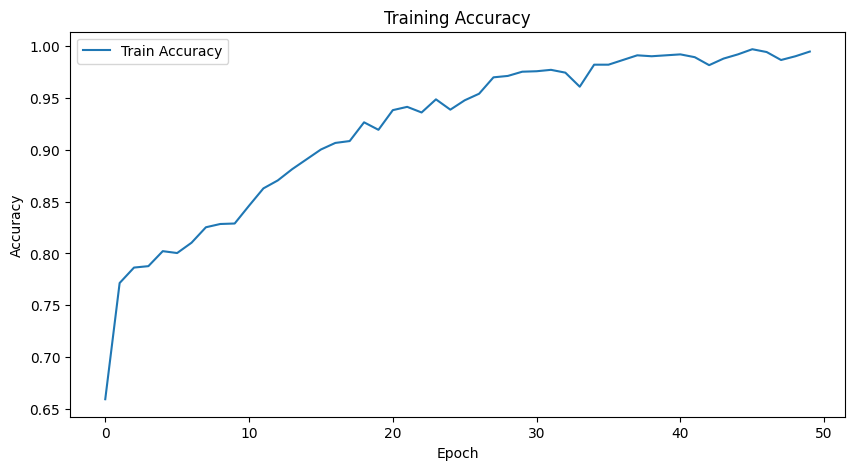

In [27]:
plt.figure(figsize=(10,5))
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

### Evaluating the Model on Test Data

We evaluate the trained model on the test dataset to measure its performance on unseen data.  

- The model is set to evaluation mode using `network.eval()`.  
- Gradients are disabled with `torch.no_grad()` to save memory and computation.  
- We compute the loss and accuracy over the test dataset to assess generalization.


In [28]:
test_losses = []
test_accuracies = []

network.eval()  # set model to evaluation mode
correct = 0
total = 0
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.float()

        outputs = network(inputs)
        loss = loss_fn(outputs, labels)
        test_loss += loss.item()

        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.numel()

test_accuracy = correct / total
test_loss = test_loss / len(test_loader)

test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

print(f"Test Accuracy: {test_accuracy:.6f}, Test Loss: {test_loss:.6f}")


Test Accuracy: 0.989170, Test Loss: 0.098049
